# Desciption of the Dataset


- instant: record index
- dteday : date
- season : season (1:winter, 2:spring, 3:summer, 4:fall)
- yr : year (0: 2011, 1:2012)
- mnth : month ( 1 to 12)
- hr : hour (0 to 23)
- holiday : weather day is holiday or not (extracted from [Web Link])
- weekday : day of the week
- workingday : if day is neither weekend nor holiday is 1, otherwise is 0.
+ weathersit :
- 1: Clear, Few clouds, Partly cloudy, Partly cloudy
- 2: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist
- 3: Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds
- 4: Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog
- temp : Normalized temperature in Celsius. The values are derived via (t-t_min)/(t_max-t_min), t_min=-8, t_max=+39 (only in hourly scale)
- atemp: Normalized feeling temperature in Celsius. The values are derived via (t-t_min)/(t_max-t_min), t_min=-16, t_max=+50 (only in hourly scale)
- hum: Normalized humidity. The values are divided to 100 (max)
- windspeed: Normalized wind speed. The values are divided to 67 (max)
- casual: count of casual users
- registered: count of registered users
- cnt: count of total rental bikes including both casual and registered 

# Libraries and Configurations setup

In [28]:
import numpy as np
import pandas as pd

from sklearn import metrics
from sklearn import preprocessing
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline

import seaborn as sns
import matplotlib 
import matplotlib.pyplot as plt
matplotlib.style.use('ggplot')
%matplotlib inline

from fileservice import CSVService
from config import global_config as glob
from config.yaml_config import model_parameters
from transformers.custom_transformers import *
from model.estimator import ensembleRegressor

## Data Loading

In [29]:
input_file = model_parameters['arguments']['csvtables']['input_file_name']
output_file = model_parameters['arguments']['csvtables']['output_file_name']
csv = CSVService(input_file_path = input_file, 
                 output_file_path = output_file, 
                 root_path = glob.package_dir, new_cols = model_parameters['arguments']['data_columns'])
bike_data = csv.doRead()

CSV Service Read from File: C:/Users/Vamshi/__Workspace__/jda/data/hour.csv


In [30]:
bike_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17379 entries, 0 to 17378
Data columns (total 17 columns):
row_index                    17379 non-null int64
date                         17379 non-null object
season                       17379 non-null int64
year                         17379 non-null int64
month                        17379 non-null int64
hour                         17379 non-null int64
holiday_or_not               17379 non-null int64
weekday                      17379 non-null int64
workingday_or_not            17379 non-null int64
weather_state                17379 non-null int64
normalized_temp              17379 non-null float64
normalized_feeling_temp      17379 non-null float64
humidity                     17379 non-null float64
wind_speed                   17379 non-null float64
count_of_casual_users        17379 non-null int64
count_of_registered_users    17379 non-null int64
total_rental_bikes           17379 non-null int64
dtypes: float64(4), int64(12), o

# Explorative analysis

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001F9E995F1D0>,
      dtype=object)

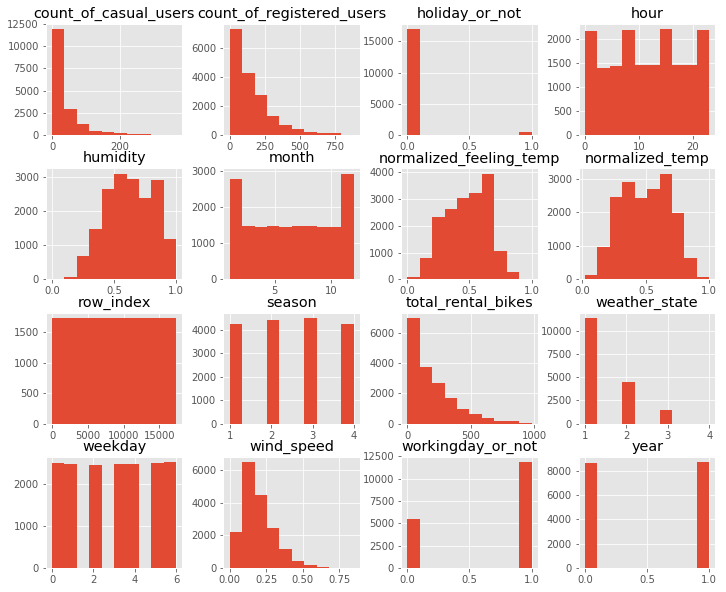

In [31]:
bike_data.hist(figsize=(12,10))

Text(0.5, 1.0, 'Pattern based on seasonal changes for each hour in a day')

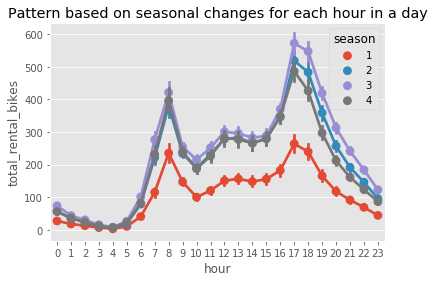

In [32]:
ax2 = sns.pointplot(data=bike_data[['hour', 'total_rental_bikes', 'season']], x='hour', y='total_rental_bikes', hue='season')
ax2.set_title('Pattern based on seasonal changes for each hour in a day')

Text(0.5, 1.0, 'Total count per hour based on holiday and working day')

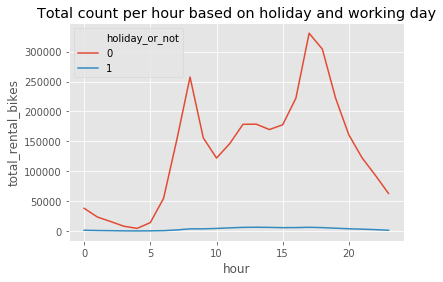

In [33]:
holiday_staus = bike_data.groupby(['holiday_or_not','hour']).agg({'total_rental_bikes': 'sum'}).reset_index().sort_values('total_rental_bikes', ascending=False)
ax = sns.lineplot(data=holiday_staus, x='hour', y='total_rental_bikes', hue='holiday_or_not')
ax.set_title('Total count per hour based on holiday and working day')

- The below graph indicate the rise in number of rentals in two years

Text(0.5, 1.0, 'Pattern based on two give years ')

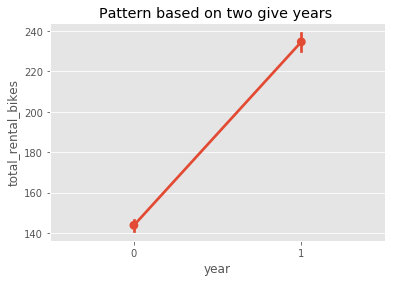

In [34]:
ax2 = sns.pointplot(data=bike_data[['year', 'total_rental_bikes']], x='year', y='total_rental_bikes')
ax2.set_title('Pattern based on two give years ')

### In addition to the above plot, the plot below  has :
- the pattern that average count of rental in the first few range of examples is around 600(in first year)
- the last few range of examples   have an average of 800(in next year)

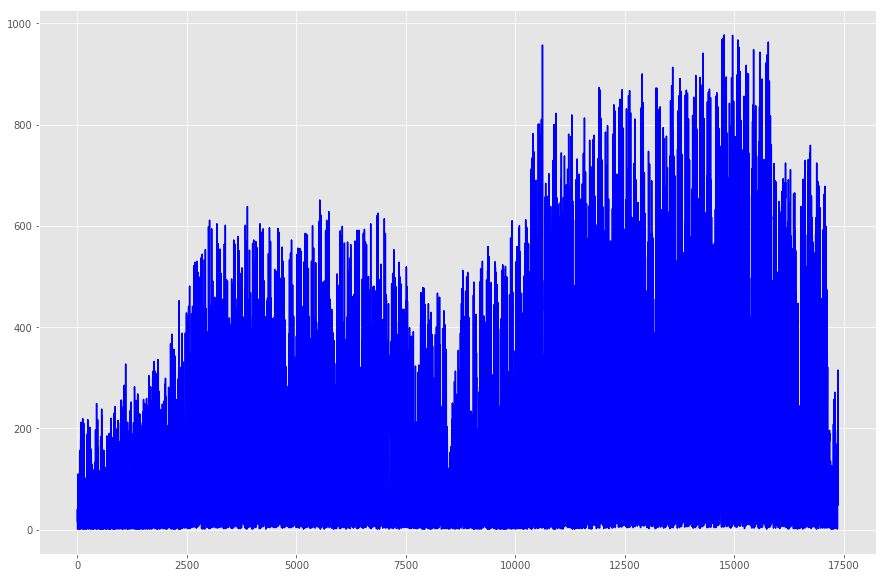

In [35]:
plt.figure(figsize=(15,10))
plt.plot(bike_data['total_rental_bikes'], color='blue')
plt.show()

### Seasonal pattern over the rentals count 

Text(0, 0.5, 'Total count')

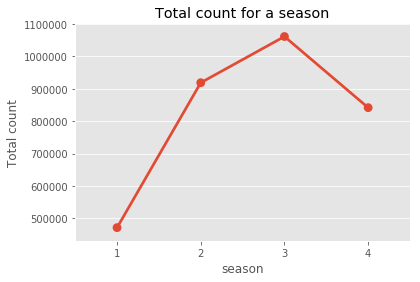

In [36]:
season_status = bike_data.groupby(['season']).agg({'total_rental_bikes': 'sum'}).reset_index().sort_values('total_rental_bikes', ascending=False)
ax1 = sns.pointplot(data=season_status, x='season', y='total_rental_bikes')
ax1.set_title('Total count for a season')
ax1.set_ylabel('Total count')

In [37]:
import plotly.express as px
fig = px.line(bike_data[['season','total_rental_bikes','hour']], x="hour", y="total_rental_bikes", color='season')
fig.show()

### Correlation matrix view between columns

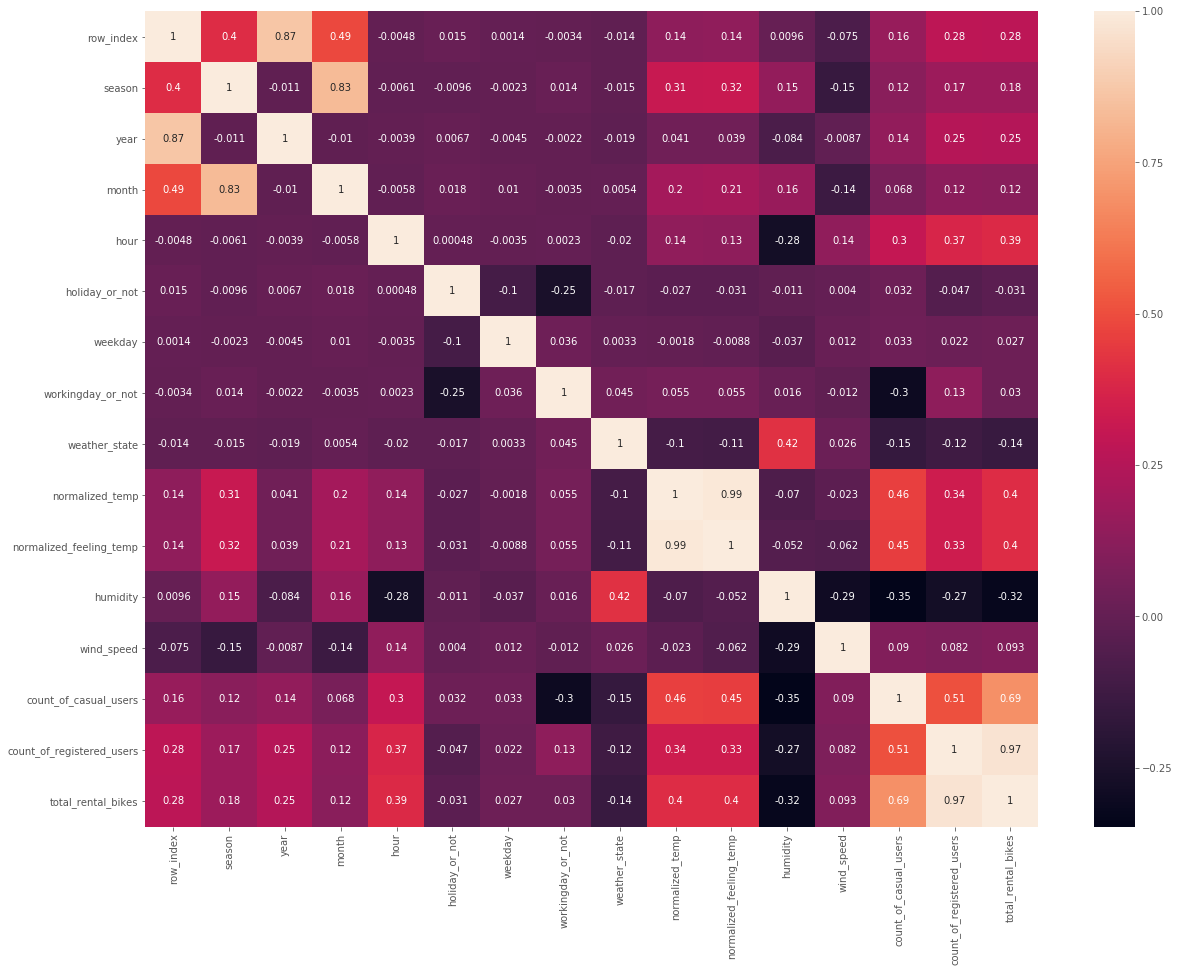

In [38]:
plt.figure(figsize=(20,15))
sns.heatmap(bike_data.corr(), annot=True)